#  Abgabe 8

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

# Klassennamen:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']


from torchvision import datasets, transforms
data_path = '../data-unversioned/p1ch6/'

# Datensatz Training
# Augmenatation
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

# Datensatz Validierung
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

# Daten für 2 'airplane' und 'bird'
import itertools

label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

device = (torch.device('cuda') if torch.cuda.is_available()
else torch.device('cpu'))
print(f"Training on device {device}.")


import datetime

# Trainingsloop
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, val_loader):
    loss_Nvall = np.zeros(n_epochs)
    loss_Ntrain = np.zeros(n_epochs)
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            losses_train = loss_fn(outputs, labels)
            optimizer.zero_grad()
            losses_train.backward()
            optimizer.step()
            loss_train += losses_train.item()

        loss_val = 0.0
        for imgs, labels in val_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            losses_val = loss_fn(outputs, labels)
            optimizer.zero_grad()
            optimizer.step()
            loss_val += losses_val.item()

        if epoch == 1 or epoch % 10 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train / len(train_loader):.4f},"
                  f" Validation loss {loss_val / len(val_loader):.4f}")

        loss_Nvall[epoch-1] = loss_val / len(val_loader)
        loss_Ntrain [epoch-1] = loss_train / len(train_loader)

    return loss_Ntrain, loss_Nvall



# Model Paper:  Wide Residual Networks
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(BasicBlock, self).__init__()

        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)

        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x
        out = self.bn1(x)
        out = self.relu1(out)
        out = self.conv1(out)

        out = self.bn2(out)
        out = self.relu2(out)
        out = self.conv2(out)
        out += self.shortcut(residual)
        return out


class WRN(nn.Module):
    def __init__(self, depth, widening_factor, num_classes):
        super(WRN, self).__init__()
        assert (depth - 4) % 6 == 0
        self.n = (depth - 4) // 6
        self.widening_factor = widening_factor
        self.in_channels = 16
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(16 * self.widening_factor, stride=1)
        self.layer2 = self._make_layer(32 * self.widening_factor, stride=2)
        self.layer3 = self._make_layer(64 * self.widening_factor, stride=2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64 * self.widening_factor, num_classes)

    def _make_layer(self, out_channels, stride):
        layers = []
        layers.append(BasicBlock(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(self.n - 1):
            layers.append(BasicBlock(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                           shuffle=False)

depth = 28
widening_factor = 2
num_classes = 2
model = WRN(depth, widening_factor, num_classes).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

loss_t, loss_v = training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
    val_loader = val_loader
)



100%|██████████| 170498071/170498071 [00:03<00:00, 45691623.47it/s]


Extracting ../data-unversioned/p1ch6/cifar-10-python.tar.gz to ../data-unversioned/p1ch6/
Files already downloaded and verified
Training on device cuda.
Epoch 1, Training loss 0.4625, Validation loss 0.4107
Epoch 10, Training loss 0.1883, Validation loss 0.2937
Epoch 20, Training loss 0.0210, Validation loss 0.4505
Epoch 30, Training loss 0.0307, Validation loss 0.8201
Epoch 40, Training loss 0.0035, Validation loss 0.5628
Epoch 50, Training loss 0.0043, Validation loss 0.5841
Epoch 60, Training loss 0.0007, Validation loss 0.5930
Epoch 70, Training loss 0.0080, Validation loss 0.5649
Epoch 80, Training loss 0.0009, Validation loss 1.0504
Epoch 90, Training loss 0.0001, Validation loss 0.6544
Epoch 100, Training loss 0.0122, Validation loss 0.4003


In [2]:
# Validierung Paper
all_acc_dict = collections.OrderedDict()

def validate(model, train_loader, val_loader):
    accdict = {}
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <1>
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        accdict[name] = correct / total
    return accdict

print(validate(model, train_loader, val_loader))

Accuracy train: 1.00
Accuracy val: 0.90
{'train': 0.9999, 'val': 0.902}


In [3]:
# Model Buch
class NetRes(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
        padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2,
        kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

# Model Buch Training
# Trainingsdatensatz: ohne Augmentation

cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616)),
    ]))
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]


model_book = NetRes(n_chans1=32).to(device=device)

optimizer = optim.SGD(model_book.parameters(), lr=3e-3)
loss_fn = nn.CrossEntropyLoss()


train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)


loss_t_book, loss_v_book = training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model_book,
    loss_fn = loss_fn,
    train_loader = train_loader,
    val_loader = val_loader,)


Files already downloaded and verified
Epoch 1, Training loss 0.6842, Validation loss 0.6659
Epoch 10, Training loss 0.4320, Validation loss 0.4134
Epoch 20, Training loss 0.3494, Validation loss 0.3439
Epoch 30, Training loss 0.3192, Validation loss 0.3239
Epoch 40, Training loss 0.3004, Validation loss 0.3296
Epoch 50, Training loss 0.2811, Validation loss 0.2970
Epoch 60, Training loss 0.2676, Validation loss 0.3181
Epoch 70, Training loss 0.2580, Validation loss 0.2735
Epoch 80, Training loss 0.2437, Validation loss 0.2673
Epoch 90, Training loss 0.2337, Validation loss 0.2751
Epoch 100, Training loss 0.2252, Validation loss 0.2610


In [4]:
# Validierung Buch

all_acc_dict = collections.OrderedDict()

def validate_book(model, train_loader, val_loader):
    accdict = {}
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model_book(imgs)
                _, predicted = torch.max(outputs, dim=1) # <1>
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        accdict[name] = correct / total
    return accdict

print(validate_book(model_book, train_loader, val_loader))


Accuracy train: 0.91
Accuracy val: 0.89
{'train': 0.9123, 'val': 0.8905}


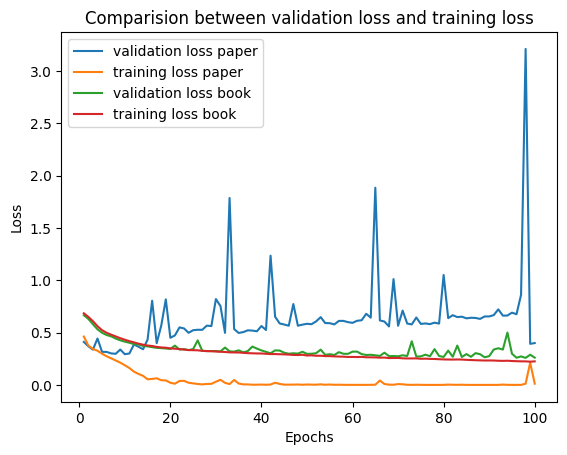

In [5]:
# Plot Loss/Epochen
epochs = np.arange(1, 101, 1)

plt.plot(epochs,loss_v, label='validation loss paper')
plt.plot(epochs,loss_t, label='training loss paper')
plt.plot(epochs,loss_v_book, label='validation loss book')
plt.plot(epochs,loss_t_book, label='training loss book')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Comparision between validation loss and training loss")
plt.show()

Die Accuracy bei dem Model aus dem Paper (Wide Residual Networks) beträgt für die Trainingsdaten 1.0 und für die Validierungsdaten 0.9. Die Accuracy mit dem Model aus dem Buch (ResNet) beträgt für die Trainingsdaten 0.91 und für die Validierungsdaten 0.89. Anhand der Accuracy der Validierungsdaten könnte man darauf schließen, dass beide Modelle fast gleich gut sind. Aber bei der Betrachtung der Accuracy der Trainingsdaten und des steigenden Validierungslosses kann man darauf schließen, dass bei dem Modell aus dem Paper ein Übertraining erfolgt ist.